Baseline MobileNetV2 on CIFAR-10 dataset

In [1]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [2]:
# ---------------------------------
# Reproducibility Configuration
# ---------------------------------
import torch
import numpy as np
import random
import os

def set_seed(seed=42):
    """
    Sets seed for reproducibility across:
    - Python
    - NumPy
    - PyTorch (CPU + GPU)
    - cuDNN (deterministic)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Make cuDNN deterministic (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Ensure hash-based ops are deterministic
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set to: {seed}")

# Call the seed function
set_seed(42)

Random seed set to: 42


In [3]:
def create_mobilenetv2_cifar10(num_classes=10, pretrained=True):
    """
    Create a MobileNetV2 model adapted for CIFAR-10.
    """
    if pretrained:
        print("Load ImageNet weights")
        weights = MobileNet_V2_Weights.IMAGENET1K_V1
        model = mobilenet_v2(weights=weights)
    else:
        model = mobilenet_v2(weights=None)

    # Replace classifier (last linear layer) for CIFAR-10
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model


In [4]:
def get_cifar10_loaders(data_dir, batch_size=128, num_workers=4):
    """
    Returns (trainloader, testloader) for CIFAR-10 with good augmentations.
    """
    # ImageNet-like normalization
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # CIFAR-10 images are 32x32; we upscale to 224x224 for MobileNetV2
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        normalize,
        transforms.RandomErasing(p=0.2)
    ])

    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=train_transform
    )

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=test_transform
    )

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    return trainloader, testloader


In [5]:
def plot_curves(history, out_prefix="mobilenetv2_cifar10"):
    """
    Plot train/val loss and accuracy curves and save them as PNGs.
    history: dict with keys:
        'train_loss', 'train_acc', 'val_loss', 'val_acc'
    """
    epochs = range(len(history["train_loss"]))

    # Loss curve
    plt.figure()
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val/Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss vs Epochs")
    plt.savefig(f"{out_prefix}_loss.png", bbox_inches="tight")
    plt.show()
    plt.close()

    # Accuracy curve
    plt.figure()
    plt.plot(epochs, history["train_acc"], label="Train Top-1")
    plt.plot(epochs, history["val_acc"], label="Val/Test Top-1")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy vs Epochs")
    plt.savefig(f"{out_prefix}_accuracy.png", bbox_inches="tight")
    plt.show()
    plt.close()


In [6]:
class LabelSmoothingCrossEntropy(nn.Module):
    """
    Cross-entropy with label smoothing.
    """
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, preds, target):
        num_classes = preds.size(1)
        log_preds = torch.log_softmax(preds, dim=1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_preds)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_preds, dim=1))


def accuracy(output, target, topk=(1,)):
    """
    Computes the top-k accuracy for the specified values of k.
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Get top-k indices
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # Compare with targets expanded
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


In [7]:
def train_one_epoch(model, criterion, optimizer, dataloader, device, epoch, scaler=None):
    model.train()
    running_loss = 0.0
    running_top1 = 0.0
    total = 0

    start_time = time.time()

    for i, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad()

        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        top1, = accuracy(outputs, targets, topk=(1,))
        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_top1 += top1.item() * bs
        total += bs

        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch}] Step [{i+1}/{len(dataloader)}] "
                f"Loss: {running_loss / total:.4f} | "
                f"Top-1: {running_top1 / total:.2f}%"
            )

    epoch_loss = running_loss / total
    epoch_acc1 = running_top1 / total
    elapsed = time.time() - start_time
    print(
        f"Epoch [{epoch}] TRAIN - "
        f"Loss: {epoch_loss:.4f} | Top-1: {epoch_acc1:.2f}% | "
        f"Time: {elapsed:.1f}s"
    )
    return epoch_loss, epoch_acc1


@torch.no_grad()
def evaluate(model, criterion, dataloader, device, epoch="TEST"):
    model.eval()
    running_loss = 0.0
    running_top1 = 0.0
    total = 0

    for inputs, targets in dataloader:
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        top1, = accuracy(outputs, targets, topk=(1,))
        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_top1 += top1.item() * bs
        total += bs

    loss = running_loss / total
    acc1 = running_top1 / total
    print(f"Epoch [{epoch}] VALID - Loss: {loss:.4f} | Top-1: {acc1:.2f}%")
    return loss, acc1


In [8]:
class Config:
    data_dir = "./data"           # For Colab, use "/content/data"
    epochs = 30
    batch_size = 128
    lr = 0.05
    weight_decay = 4e-5
    num_workers = 4
    label_smoothing = 0.1
    no_pretrained = False         # Set True to disable ImageNet pretraining
    save_path = "mobilenetv2_cifar10_best.pth"
    resume = ""                   # Path to checkpoint, or "" to start fresh
    mixed_precision = False        # Use AMP if GPU is available

cfg = Config()
print("Config:", vars(cfg))


Config: {}


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Data
trainloader, testloader = get_cifar10_loaders(
    data_dir=cfg.data_dir,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
)

# Model
model = create_mobilenetv2_cifar10(
    num_classes=10,
    pretrained=not cfg.no_pretrained,
)
model = model.to(device)

# Optionally resume
start_epoch = 0
best_acc = 0.0
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

if cfg.resume and os.path.isfile(cfg.resume):
    print(f"Loading checkpoint from {cfg.resume}")
    checkpoint = torch.load(cfg.resume, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    start_epoch = checkpoint.get("epoch", 0) + 1
    best_acc = checkpoint.get("best_acc", 0.0)
    print(f"Resumed from epoch {start_epoch}, best_acc={best_acc:.2f}%")

# Loss, optimizer, scheduler
criterion = LabelSmoothingCrossEntropy(smoothing=cfg.label_smoothing)

# Only decay weights of conv/linear (not bias, not norm layers)
decay, no_decay = [], []
for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    if param.ndimension() == 1 or name.endswith(".bias"):
        no_decay.append(param)
    else:
        decay.append(param)

optimizer = optim.SGD(
    [
        {"params": decay, "weight_decay": cfg.weight_decay},
        {"params": no_decay, "weight_decay": 0.0},
    ],
    lr=cfg.lr,
    momentum=0.9,
    nesterov=True,
)

# Cosine LR schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=cfg.epochs, eta_min=1e-4
)

scaler = torch.cuda.amp.GradScaler() if (cfg.mixed_precision and device == "cuda") else None


Using device: cuda


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Load ImageNet weights


100%|██████████| 13.6M/13.6M [00:00<00:00, 114MB/s] 


In [10]:
for epoch in range(start_epoch, cfg.epochs):
    print(f"\n=== Epoch {epoch}/{cfg.epochs - 1} ===")
    train_loss, train_acc = train_one_epoch(
        model, criterion, optimizer, trainloader, device, epoch, scaler
    )
    val_loss, val_acc = evaluate(model, criterion, testloader, device, epoch)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        state = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "best_acc": best_acc,
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
        }
        torch.save(state, cfg.save_path)
        print(f"New best acc: {best_acc:.2f}%. Saved checkpoint to {cfg.save_path}.")

print(f"\nTraining finished. Best Top-1 accuracy: {best_acc:.2f}%")
print(f"Best model saved to: {cfg.save_path}")



=== Epoch 0/29 ===
Epoch [0] Step [100/391] Loss: 1.6947 | Top-1: 52.66%
Epoch [0] Step [200/391] Loss: 1.4686 | Top-1: 61.30%
Epoch [0] Step [300/391] Loss: 1.3590 | Top-1: 65.51%
Epoch [0] TRAIN - Loss: 1.3012 | Top-1: 67.85% | Time: 194.9s
Epoch [0] VALID - Loss: 1.0182 | Top-1: 79.47%
New best acc: 79.47%. Saved checkpoint to mobilenetv2_cifar10_best.pth.

=== Epoch 1/29 ===
Epoch [1] Step [100/391] Loss: 1.0593 | Top-1: 77.60%
Epoch [1] Step [200/391] Loss: 1.0524 | Top-1: 78.09%
Epoch [1] Step [300/391] Loss: 1.0428 | Top-1: 78.47%
Epoch [1] TRAIN - Loss: 1.0360 | Top-1: 78.81% | Time: 212.1s
Epoch [1] VALID - Loss: 0.8756 | Top-1: 86.49%
New best acc: 86.49%. Saved checkpoint to mobilenetv2_cifar10_best.pth.

=== Epoch 2/29 ===
Epoch [2] Step [100/391] Loss: 0.9986 | Top-1: 80.09%
Epoch [2] Step [200/391] Loss: 0.9935 | Top-1: 80.40%
Epoch [2] Step [300/391] Loss: 0.9855 | Top-1: 80.74%
Epoch [2] TRAIN - Loss: 0.9841 | Top-1: 80.78% | Time: 212.2s
Epoch [2] VALID - Loss: 0.8117

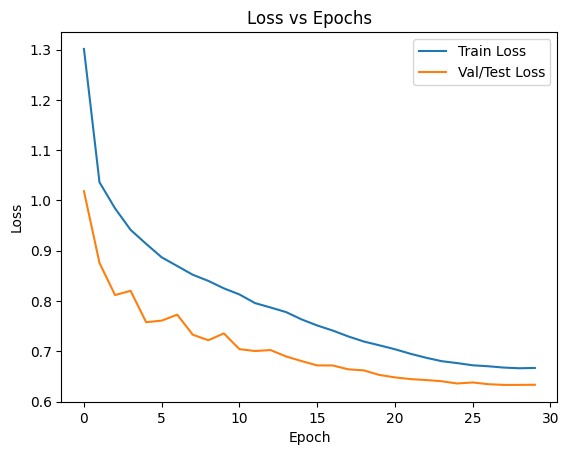

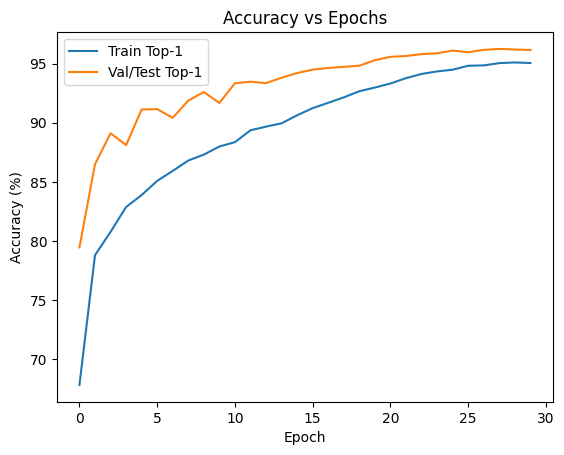

Saved loss/accuracy curves to:
 mobilenetv2_cifar10_loss.png
 mobilenetv2_cifar10_accuracy.png


In [11]:
plot_curves(history, out_prefix="mobilenetv2_cifar10")

print("Saved loss/accuracy curves to:")
print(" mobilenetv2_cifar10_loss.png")
print(" mobilenetv2_cifar10_accuracy.png")